<a href="https://colab.research.google.com/github/surajsrivathsa/mri_harmonizatiom/blob/main/DisentanglementNewNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preamble

In [ ]:
# !pip install --upgrade nibabel
!pip install torchviz
!pip install wandb --upgrade
!pip install intensity-normalization

  Created wheel for torchviz: filename=torchviz-0.0.2-cp37-none-any.whl size=4152 sha256=6bfc6ae4d561e7309543b6f4faf870395a1d39a5caa0b451e20a3724387c30dd
  Stored in directory: /root/.cache/pip/wheels/01/26/58/026ffd533dbe8b3972eb423da9c7949beca68d1c98ed9e8624
Successfully built torchviz
     |████████████████████████████████| 1.8MB 7.5MB/s 
     |████████████████████████████████| 102kB 12.5MB/s 
     |████████████████████████████████| 133kB 36.0MB/s 
     |████████████████████████████████| 163kB 33.0MB/s 
     |████████████████████████████████| 71kB 9.8MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6502 sha256=d8e9e9ff37aa38c56df40433a68cc337b8dd303998de87749a04694be78a59b9
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8807 sha256=afb9224408fbd5f4fc57f8a3b83963466e0175af2f62728b22e614a44a35a9cd
  Stored 

In [ ]:
import warnings
import os
warnings.filterwarnings("ignore")
import numpy as np
import torch
print(torch.__version__)
import torchvision
print(torchvision.__version__)
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
import nibabel as nb
import os, sys, glob
from google.colab import drive
drive.mount('/content/drive')
print()

1.8.1+cu101
0.9.1+cu101
Mounted at /content/drive



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import collections
from torch.autograd import Variable
import scipy.misc
import imageio
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import wandb
os.environ["WANDB_API_KEY"] = "4d55d2ea028525eadeb537494a02bf9ce8ead8f3"
wandb.login()

import time
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from torchviz import make_dot
import urllib
from random import randint, seed
import intensity_normalization
seed(1)

wandb: Currently logged in as: suraj110693 (use `wandb login --relogin` to force relogin)


# Dataset creation

In [ ]:
def load_4D(name, slicenum=128):
        resamplng_shape = (246, 256, 256)
        X_nb = nb.load(name)
        X_np = X_nb.dataobj
        x_dim, y_dim, z_dim = X_np.shape

        X_np = np.array(X_np)

        #use min to remove error due to normalization
        model_np = np.full((256, 256, 256), X_np.min())
        #print(x_dim, y_dim, z_dim)
        x_ltail = (resamplng_shape[0] - x_dim)//2 
        y_ltail = (resamplng_shape[1] - y_dim)//2
        z_ltail = (resamplng_shape[2] - z_dim)//2
        #print(x_ltail,y_ltail,z_ltail)

        x_rtail = resamplng_shape[0] - x_ltail - 1
        y_rtail = resamplng_shape[1] - y_ltail - 1
        z_rtail = resamplng_shape[2] - z_ltail - 1
        #print(x_rtail,y_rtail,z_rtail)
        model_np[x_ltail:x_rtail, y_ltail:y_rtail, z_ltail:z_rtail] = X_np[:, :, :]
        #z_32_slices = [3, 7, 11, 15, 19, 23, 27, 31, 35, 39, 43, 47, 51, 55, 59, 63, 67, 71, 75, 79, 83, 87, 91, 95, 99, 103, 107, 111, 115, 119, 123, 127]
        model_np = model_np[:, :, slicenum ]
        model_np = np.expand_dims(model_np, axis=0)
        #print(model_np.shape)
        #print(model_np)
        return model_np

def load_3D(name):
        X_nb = nb.load(name)
        X_np = X_nb.dataobj
        # model_np = np.full((256, 256), X_np.min())
        model_np = np.expand_dims(X_np, axis=0)
        return model_np

def imgnorm(N_I,index1=0.0001,index2=0.0001):
    I_sort = np.sort(N_I.flatten())
    I_min = I_sort[int(index1*len(I_sort))]
    I_max = I_sort[-int(index2*len(I_sort))]
    N_I =1.0*(N_I-I_min)/(I_max-I_min)
    N_I[N_I>1.0]=1.0
    N_I[N_I<0.0]=0.0
    N_I2 = N_I.astype(np.float32)
    return N_I2

def Norm_Zscore(img):
    img= (img-np.mean(img))/np.std(img) 
    return img

def save_img(I_img,savename):
    I2 = sitk.GetImageFromArray(I_img,isVector=False)
    sitk.WriteImage(I2,savename)

def create_full_brain_mask(img_np):
  img_cp_np = np.copy(img_np)
  image_shape = img_cp_np.shape
  min_intensity = np.min(img_cp_np)
  max_intensity = np.max(img_cp_np)
  img_cp_np[img_cp_np > 0.0] = 1.0
  img_cp_np[img_cp_np <= 0.0] = 0.0
  return img_cp_np

In [ ]:
# my_t1_path = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/Batch_T1_1_output"
# my_t2_path = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/Batch_T2_1_output"

my_t1_path = "/content/drive/My Drive/dataset/Batch_T1_1_fcm_corrected_input"
my_t2_path = "/content/drive/My Drive/dataset/Batch_T2_1_output"
file_names_my_t1 = sorted(glob.glob(os.path.join(my_t1_path, "*.nii.gz")))
file_names_my_t2 = sorted(glob.glob(os.path.join(my_t2_path, "*.nii.gz")))

In [ ]:
# mask_nifti_t1_imgpath = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/Batch_T1_1_mask"
# mask_nifti_t2_imgpath = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/Batch_T2_1_mask"
mask_nifti_t1_imgpath = "/content/drive/My Drive/dataset/Batch_T1_1_mask"
mask_nifti_t2_imgpath = "/content/drive/My Drive/dataset/Batch_T2_1_mask"
mask_names_my_t1 = sorted(glob.glob(os.path.join(mask_nifti_t1_imgpath, "*.nii.gz")))
mask_names_my_t2 = sorted(glob.glob(os.path.join(mask_nifti_t2_imgpath, "*.nii.gz")))

In [ ]:
class IntramodalDatasetwithPreprocess(Data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, t1_filenames, t2_filenames, iterations=1):
        'Initialization'
        self.t1_filenames = t1_filenames
        self.t2_filenames = t2_filenames
        self.t1_masknames = mask_names_my_t1
        self.t2_masknames = mask_names_my_t2
        self.norm = False
        self.iterations = iterations
  def __len__(self):
        'Denotes the total number of samples'
        return len(self.t1_filenames) * self.iterations

  def __getitem__(self, idx):
        A_idx = randint(0, len(self.t1_filenames)-1)
        B_idx = A_idx
        # B_idx = randint(0, len(self.t2_filenames)-1)
        # if (A_idx == B_idx):
        #   B_idx = (B_idx + 1) % (len(self.t1_filenames)-1)

        img_A = load_3D(self.t1_filenames[A_idx])
        # mask_A = load_3D(self.t1_masknames[A_idx])
        # img_B = load_3D(self.t1_filenames[(A_idx + 4) % len(self.t1_filenames)])
        img_B = load_3D(self.t2_filenames[B_idx])
        # mask_B = load_3D(self.t2_masknames[B_idx])
        return img_A, img_B

In [ ]:
class IntramodalInferenceDatasetwthpreprocess(Data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, t1_filenames, t2_filenames, iterations=1):
        'Initialization'
        self.t1_filenames = t1_filenames
        self.t2_filenames = t2_filenames
        self.t1_masknames = mask_names_my_t1
        self.t2_masknames = mask_names_my_t2
        self.iterations = iterations
  def __len__(self):
        'Denotes the total number of samples'
        return len(self.t1_filenames) * self.iterations

  def __getitem__(self, idx):
        'Generates one sample of data'
        A_idx = idx
        B_idx = A_idx

        img_A = load_3D(self.t1_filenames[A_idx])
        img_B = load_3D(self.t2_filenames[B_idx])
        # mask_A = load_3D(self.t1_masknames[A_idx])
        # mask_B = load_3D(self.t2_masknames[B_idx])
                       
        return img_A, img_B

In [ ]:
training_generator = Data.DataLoader(IntramodalDatasetwithPreprocess(file_names_my_t1, file_names_my_t2, 1), batch_size=5,shuffle=True, drop_last=True)

In [ ]:
for X, Y in training_generator:
  print(X.shape)
  # print(P.shape)
  print( torch.min(X[0,:,:]), torch.max(X[0,:,:]), torch.mean(X) )
  break

torch.Size([5, 1, 256, 256])
tensor(0.) tensor(1.) tensor(0.1949)


In [ ]:
inference_generator = Data.DataLoader(IntramodalInferenceDatasetwthpreprocess(file_names_my_t1, file_names_my_t2, 1), batch_size=1,shuffle=True, drop_last=True)

In [ ]:
for X, Y in inference_generator:
  print(X.shape)
  print(torch.max(X), torch.min(X))
  print(torch.max(Y), torch.min(Y))
  x_hist = torch.histc(X, bins=20, min=0, max=1).numpy()
  y_hist = torch.histc(Y, bins=20, min=0, max=1).numpy()
  print(scipy.stats.chisquare(f_obs=x_hist, f_exp=y_hist,ddof=0))
  print(scipy.stats.chisquare(f_obs=x_hist, f_exp=x_hist,ddof=0)[0])
  print("------------ --------------- ---------------")
  print(torch.histc(X, bins=20, min=0, max=1).numpy())
  print(torch.histc(Y, bins=20, min=0, max=1).numpy())
  print("------------ --------------- ---------------")
  print()
  hist,bins = np.histogram(X[0,:, :].ravel(),256,[0,1])
  print(hist)
  print(bins)
  print("------------ --------------- ---------------")
  print()
  hist,bins = np.histogram(Y[0,:, :].ravel(),256,[0,1])
  print(hist)
  print(bins)
  break

torch.Size([1, 1, 256, 256])
tensor(1.) tensor(0.)
tensor(1.) tensor(0.)
Power_divergenceResult(statistic=48201.215, pvalue=0.0)
0.0
------------ --------------- ---------------
[47429.   477.   312.  1094.   922.   489.   465.   520.   341.   434.
   489.   476.   715.  1247.   985.  1128.  1102.  1542.  4571.   798.]
[47810.   187.   111.    74.    67.   125.   750.  2767.  4177.  1539.
  1149.   723.   555.   432.   359.   242.   466.  2137.  1367.   499.]
------------ --------------- ---------------

[46988     0   130     0    91     0    78     0     0    64     0    78
     0   149     0    60     0     0    84     0    58     0    61     0
    65     0     0    70     0    65     0    57     0    59     0     0
    61     0   114     0   144     0     0   179     0   238     0   212
     0   207     0     0   178     0   326     0   142     0    98     0
     0    99     0    79     0   107     0    91     0     0    97     0
    87     0   107     0     0    81     0    84    

# Model creation

In [ ]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1), 
            nn.BatchNorm2d(mid_channels),
            nn.LeakyReLU(0.2),  
            
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1), 
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2) )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels, maxpool=False):
        super().__init__()
        if (maxpool):
          self.maxpool_conv = nn.Sequential(
              nn.MaxPool2d(2),
              DoubleConv(in_channels, out_channels))
        else:
          self.maxpool_conv = nn.Sequential(
              nn.Conv2d(in_channels, in_channels, stride=2, padding=1, kernel_size=3),
              DoubleConv(in_channels, out_channels))

    """
    
    ,
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
    """
    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=False):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.Sequential(nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2), )
            # nn.BatchNorm2d(in_channels // 2),                                                           
            # nn.LeakyReLU(0.1))
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels, with_activation=False):
        super(OutConv, self).__init__()
        if (with_activation):
          self.conv =  nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),)
        
        else:
          self.conv =  nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                                     nn.BatchNorm2d(out_channels),
                                     nn.LeakyReLU(0.2))

    def forward(self, x):
        return self.conv(x)

       
class InConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(InConv, self).__init__()
        self.conv =  nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),                                                                                                                                   
                                   nn.Sigmoid())
    def forward(self, x):
        return self.conv(x)

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False, maxpool=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc1 = InConv(n_channels, 8)
        self.inc2 = DoubleConv(8, 16)
        self.down1 = Down(16, 32,  maxpool)
        self.down2 = Down(32, 64,  maxpool)
        self.down3 = Down(64, 128, maxpool)
        self.down4 = Down(128, 256, maxpool)
        self.down5 = Down(256, 512, maxpool)
        factor = 2 if bilinear else 1
        self.down6 = Down(512, 1024 // factor, maxpool)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64 // factor, bilinear)
        self.up5 = Up(64, 32 // factor, bilinear)
        self.up6 = Up(32, 16, bilinear)
        self.outc = OutConv(16, self.n_classes)

    def forward(self, x):
        x1 = self.inc1(x)
        x1 = self.inc2(x1)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x6 = self.down5(x5)
        x7 = self.down6(x6)
        # print(x5.shape, x6.shape, x7.shape)
        x = self.up1(x7, x6)
        x = self.up2(x, x5)
        x = self.up3(x, x4)
        x = self.up4(x, x3)
        x = self.up5(x, x2)
        x = self.up6(x, x1)
        logits = self.outc(x)
        return logits

In [ ]:
class BetaHead(nn.Module):
  def __init__(self,in_channel, Cb=7):
        self.in_channel = in_channel
        self.Cb = Cb
        super(BetaHead, self).__init__()
        self.probmaps = self.probability_map(self.in_channel, self.Cb * 1)
        self.softmax_output = nn.Softmax(dim=1)

  def probability_map(self, in_channel, Cb, ks=3, st=1, pd=1, bi=False):
    layer = nn.Sequential(
                nn.Conv2d(in_channels=in_channel, out_channels = self.Cb, kernel_size=ks, stride=st, padding=pd, bias=bi),)
    return layer

  #nn.BatchNorm2d(self.Cb)
  def forward(self, x, hard_flag=True, tau=1.0, gumbel=True):  
        pmap = self.probmaps(x)

        if (gumbel):

          ohe = nn.functional.gumbel_softmax(pmap, tau=tau, hard=hard_flag, dim=1)
        else:
          # channel_positions_for_max_pixels = torch.argmax(pmap, dim=1)
          _, channel_positions_for_max_pixels = pmap.max(dim=1)
          ohe = F.one_hot(channel_positions_for_max_pixels, num_classes=self.Cb)
          ohe = ohe.permute(0, 3, 1, 2) # the channel dim would appear at end 1,256,256,channel ==> permute channel dim to second position 1,channel,256,256
          ohe = ohe.float()
           
          print(ohe.shape)
        smax = self.softmax_output(pmap)
        return pmap, ohe, smax

In [ ]:
class ThetaHead(nn.Module):
  def __init__(self,in_channel, Ct=1):
        self.in_channel = in_channel
        self.Ct = Ct

        super(ThetaHead, self).__init__()
        self.td = self.theta_head(self.in_channel)

  def theta_head(self, in_channel):
    layer = nn.Sequential(
                nn.Conv2d(in_channels=in_channel, out_channels = 32, kernel_size=64, stride=8, padding=1, bias=False),
                nn.BatchNorm2d(32),
                nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size=5, stride=4, padding=1, bias=False),
                nn.BatchNorm2d(64),
                nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=3, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(128),
                nn.Flatten(),
                nn.Linear(1152, self.Ct))
    return layer

  def forward(self, x):  
        theta_op = self.td(x)
        return theta_op

In [ ]:
class RandomizationHead(nn.Module):
  def __init__(self, Cb=7, Ct=1, randomize_flag=True):
        self.Cb = Cb
        self.Ct = Ct
        self.randomize_flag = randomize_flag
        self.img_dim = 256
        super(RandomizationHead, self).__init__()
        self.feature_map_selection_lst_recon1 = self.randomize_betas()
        self.feature_map_selection_lst_recon2 = self.randomize_betas()
        self.feature_map_selection_lst_recon3 = self.randomize_betas()
        self.feature_map_selection_lst_recon4 = self.randomize_betas()
        print("beta_selection1: {}".format(self.feature_map_selection_lst_recon1 ))
        print("beta_selection2: {}".format(self.feature_map_selection_lst_recon2 ))
        print("beta_selection3: {}".format(self.feature_map_selection_lst_recon3 ))
        print("beta_selection4: {}".format(self.feature_map_selection_lst_recon4 ))

  def randomize_betas(self):

        """ 
        - There are two betas each from image 1 and image 2 = B1, B2
        - In each B1 and B2 there are 5 channels of (128*128) same size as input image
        - For each Beta channel do a coin toss(if there are 5 channels then 5 coin tosses)
        - For each channel either pick the channel information from B1 or B2 with equal probability
        - We have a total of 5 channels from B1 and 5 channels from B2 concatenated to 10 channels tensor
        - [0,1,2,3,4] = B1; [5,6,7,8,9] = B2 ===> concatenated_Beta=[0,1,2,3,4,   5,6,7,8,9]
        - For channel1 pick between (0,5), channel2 pick between (1,6), channel3 pick between(2,7), channel4 pick between(3,8), channel5 pick between(4, 9) with equal probability
        - So there are 2^5 = 32 possible combinations=> Same is mentioned in youtube video

        """

        rnd_lst = np.random.choice(2, self.Cb, p=[0.5, 0.5]).tolist()

        for i in range(len(rnd_lst)):
          ln = len(rnd_lst) - 1
          if (rnd_lst[i] == 0):
            rnd_lst[i] = rnd_lst[i] + i
          else:
            rnd_lst[i] = rnd_lst[i] + ln + i  
          
        return rnd_lst

  def forward(self, beta1, beta2, theta1, theta2): 

    if (self.randomize_flag):

      # Get 4 randomized maps selection for 4 decoder instances
      # print("selected randomized flag")

      self.feature_map_selection_lst_recon1 = self.randomize_betas()
      self.feature_map_selection_lst_recon2 = self.randomize_betas()
      self.feature_map_selection_lst_recon3 = self.randomize_betas()
      self.feature_map_selection_lst_recon4 = self.randomize_betas()
      # print(self.feature_map_selection_lst_recon1, self.feature_map_selection_lst_recon2, self.feature_map_selection_lst_recon3, self.feature_map_selection_lst_recon4)
      
      # Reconstruct theta to match the dimensionality of beta to 128*128
      batch_size = beta1.shape[0] 
      theta1_reconstructed = theta1.repeat(1, self.img_dim, self.img_dim).reshape(batch_size, self.Ct, self.img_dim, self.img_dim)
      theta2_reconstructed = theta2.repeat(1, self.img_dim, self.img_dim).reshape(batch_size, self.Ct, self.img_dim, self.img_dim)


      # Use the randomized map selection to select  channels from both betas
      beta = torch.cat((beta1, beta2), dim=1)

      beta_recon1 = beta[:,self.feature_map_selection_lst_recon1, :, : ]
      beta_recon2 = beta[:,self.feature_map_selection_lst_recon2, :, : ]
      beta_recon3 = beta[:,self.feature_map_selection_lst_recon3, :, : ]
      beta_recon4 = beta[:,self.feature_map_selection_lst_recon4, :, : ]

      # Combine spatially reconstructed theta and randomized beta feature maps

      input_recon1 = torch.cat((beta_recon1, theta1_reconstructed), 1)
      input_recon2 = torch.cat((beta_recon2, theta2_reconstructed), 1)
      input_recon3 = torch.cat((beta_recon3, theta1_reconstructed), 1)
      input_recon4 = torch.cat((beta_recon4, theta2_reconstructed), 1)
    
    else:
      # Reconstruct theta to match the dimensionality of beta to 128*128
      batch_size = beta1.shape[0] 
      theta1_reconstructed = theta1.repeat(1, self.img_dim, self.img_dim).reshape(batch_size, self.Ct, self.img_dim, self.img_dim)
      theta2_reconstructed = theta2.repeat(1, self.img_dim, self.img_dim).reshape(batch_size, self.Ct, self.img_dim, self.img_dim)

      input_recon1 = torch.cat((beta1, theta1_reconstructed), 1)
      input_recon2 = torch.cat((beta2, theta2_reconstructed), 1)
      input_recon3 = torch.cat((beta1, theta1_reconstructed), 1)
      input_recon4 = torch.cat((beta2, theta2_reconstructed), 1)

    return input_recon1, input_recon2, input_recon3, input_recon4

In [ ]:
class ReconstructionHead(nn.Module):
  def __init__(self,in_channel):
        self.in_channel = in_channel
        super(ReconstructionHead, self).__init__()
        self.reconstruction_head = self.reconstruct()

  def reconstruct(self):
    layer = nn.Sequential(nn.Conv2d(in_channels=self.in_channel, out_channels=1, stride=1, padding=1, kernel_size=3, bias=False ),  
                          nn.Sigmoid())
    return layer

  def forward(self, input_recon): 
      # batch_size = input_recon.shape[0] 
      # theta_reconstructed = theta.repeat(1, 128, 128).reshape(batch_size, self.Ct, 128, 128)
      # x_in = torch.cat((beta, theta_reconstructed), 1)
      rh = self.reconstruction_head(input_recon)
      return rh

In [ ]:
class CompleteModel(nn.Module):
  def __init__(self, n_channels=1, n_classes=16, bilinear=False, Cb=5, Ct=1, device="cuda", randomize_flag=True, gumbel=True, maxpool=False, tau_min=0.5):
        self.device = device
        self.Cb = 4
        self.Ct = 1
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.randomize_flag = randomize_flag
        self.gumbel = gumbel
        self.maxpool= maxpool
        self.tau_min = tau_min
        super(CompleteModel, self).__init__()

        self.encoder_unet_model = UNet(self.n_channels, self.n_classes, bilinear=self.bilinear, maxpool=self.maxpool).to(device)
        self.betahead = BetaHead(self.n_classes, self.Cb).to(device)
        self.thetahead = ThetaHead(self.n_classes, self.Ct).to(device)
        self.randomizehead = RandomizationHead(self.Cb, self.Ct, self.randomize_flag).to(device)
        self.decoder_unet_model = UNet(self.Cb + self.Ct, self.n_classes, bilinear=self.bilinear, maxpool=self.maxpool).to(device)
        self.reconstructionhead = ReconstructionHead( self.n_classes).to(device)


      

  def forward(self, X, Y, epoch, hard_flag= True, hard_epoch=120.0): 
    X = X.float().to(self.device)
    Y = Y.float().to(self.device)

    x_size = X.size()
    batch_size=x_size[0]

    annelaling_tau = max(1.0 - epoch/hard_epoch, self.tau_min)
    # Send images to encoder unet and get 16 channel output
    # 16 channels from encoder unet fed to betahead to get 5 channels of anatomy
    # Same 16 channels fed to thetahead to produce a vector to represent protocol

    u_x = self.encoder_unet_model(X)
    p_x, o_x, s_x = self.betahead(u_x, hard_flag=hard_flag, tau=annelaling_tau, gumbel=self.gumbel )
    t_x  = self.thetahead(u_x)

    u_y = self.encoder_unet_model(Y)
    p_y, o_y, s_y = self.betahead(u_y, hard_flag=hard_flag, tau=annelaling_tau, gumbel = self.gumbel )
    t_y  = self.thetahead(u_y)

    # randomize Beta and concatenate theta
    input_recon1, input_recon2, input_recon3, input_recon4 = self.randomizehead(o_x, o_y, t_x, t_y)

    # Pass the concatenated randomized betas with theta to decoder unet to get 16 channel output
    d1 = self.decoder_unet_model(input_recon1)
    d2 = self.decoder_unet_model(input_recon2)
    d3 = self.decoder_unet_model(input_recon3)
    d4 = self.decoder_unet_model(input_recon4)

    # 16 channel output from decoder unet is fed to reconstruction head to reprocuce input image according to the theta
    # If theta is theta1 then image represents T1 weightesd, else tehta2 represents T2 weighted
    r1 = self.reconstructionhead(d1)
    r2 = self.reconstructionhead(d2)
    r3 = self.reconstructionhead(d3)
    r4 = self.reconstructionhead(d4)
    return u_x, u_y, d1, d2, d3, d4, o_x, o_y, t_x, t_y, r1, r2, r3, r4

# Training

In [ ]:
try:
    complete_model
except NameError:
    print("Variables don't exists, hence cannot delete!")
else:
    del complete_model
    # del encoder_unet_model, decoder_unet_model, betahead, thetahead, randomizehead, reconstructionhead
    torch.cuda.empty_cache()
    print("Deleted model varialbles")

  

Deleted model varialbles


In [ ]:
encoder_unet_model = UNet(1, 16, bilinear=True).to("cuda")
betahead = BetaHead(16, Cb=4).to("cuda")
thetahead = ThetaHead(16, Ct=1).to("cuda")

# betacomparehead = ReconstructionHead(5, 5, 1).to("cuda")
randomizehead = RandomizationHead(Cb=4, Ct=1).to("cuda")

decoder_unet_model = UNet(5, 16, bilinear=True).to("cuda")
reconstructionhead = ReconstructionHead(16).to("cuda")


beta_selection1: [4, 1, 2, 3]
beta_selection2: [0, 5, 6, 3]
beta_selection3: [4, 5, 2, 7]
beta_selection4: [4, 5, 2, 7]


In [ ]:
complete_model = CompleteModel(gumbel=True, maxpool=True, bilinear=True,  tau_min = 0.4).to("cuda")

beta_selection1: [4, 5, 6, 3]
beta_selection2: [0, 5, 2, 3]
beta_selection3: [4, 5, 2, 7]
beta_selection4: [4, 1, 6, 3]


In [ ]:
wandb.config = dict(
    epochs=251,    
    batch_size=5,
    learning_rate=0.001,
    hyperparam1=1.0,
    hyperparam2=1.0,
    lmda=0.0005,
    dataset="MRI-IXI-T1,T2",
    architecture="UNET-CNN")

config = wandb.config

In [ ]:
reconstruction_loss = nn.MSELoss()
similarity_loss = torch.nn.CosineSimilarity(dim=2, eps=1e-08)
hyperparam1 = config["hyperparam1"]

# We need to increase cosine similarity hence multiply by negative sign. In tensorflow the cosine loss comes prebuilt with -1 multiplied, In pytorch it is not
hyperparam2 = config["hyperparam2"]
lmbda = config["lmda"]
lr=config["learning_rate"]

In [ ]:
# optimizer = torch.optim.Adam( list( encoder_unet_model.parameters())   + list( betahead.parameters() ) + list(thetahead.parameters())  + 
#                               list( decoder_unet_model.parameters()) + list( reconstructionhead.parameters()) + list(randomizehead.parameters()) , lr=lr ) 


optimizer = torch.optim.Adam( complete_model.parameters(), lr=lr ) 

#+ list(randomizehead.parameters()) + list( decoder_unet_model.parameters()) + list(betacomparehead.parameters())  + list(betacomparehead.parameters())
model_dir = '/content/drive/My Drive/Image_Registration_Project/disentangled_latent_space'

if not os.path.isdir(model_dir):
  os.mkdir(model_dir)

In [ ]:
def fullmodel_one_epoch_run1(epoch=1):
  example_number = 0
  reconstruction_loss_lst = []
  similarity_loss_lst = []
  total_loss_lst = []
  cosine_similarity_loss_lst = []
  histogram_similarity_loss_lst = []
  tones = torch.ones(size=(256, 256)).to("cuda")
  teps = torch.Tensor([1e-12]).to("cuda")
  for X,Y in training_generator:

    X = X.float().to("cuda")
    Y = Y.float().to("cuda")
    x_size = X.size()
    batch_size=x_size[0]

    u_x, u_y, d1, d2, d3, d4, o_x, o_y, t_x, t_y, r1, r2, r3, r4 = complete_model(X, Y, epoch, hard_epoch=220.0)

    #Find reconsturction MSE loss between images
    # Here we pass theta 1 and theta 2 alternately hence we should compare with T1 and T2 alternatiely
    recon_loss_1 = reconstruction_loss(X, r1)
    recon_loss_2 = reconstruction_loss(Y, r2)
    recon_loss_3 = reconstruction_loss(X, r3)
    recon_loss_4 = reconstruction_loss(Y, r4)

    recon_loss = ((recon_loss_1 + recon_loss_2 + recon_loss_3 + recon_loss_4 )/4.0)

    sim_loss_cosine = 1.0 -  similarity_loss(o_x.view(batch_size, 4, -1), o_y.view(batch_size, 4, -1)).mean()

    sim_loss = sim_loss_cosine

    total_loss = hyperparam1 * recon_loss + hyperparam2 * lmbda * sim_loss

    optimizer.zero_grad()          
    total_loss.backward() 
    optimizer.step()

    reconstruction_loss_lst.append(recon_loss.detach().cpu().numpy().item())
    cosine_similarity_loss_lst.append(sim_loss_cosine.detach().cpu().numpy().item())
    total_loss_lst.append(total_loss.detach().cpu().numpy().item())
    # print("============= =============== ===========")

    del X, Y, u_x, t_x, u_y, t_y, r1, r2, r3, r4, d1, d2, d3, d4 
    torch.cuda.empty_cache()    
    example_number = example_number + 1
    

  if (epoch%50 == 0):
    modelname = model_dir + '/' + "latent_space_harmonization_v2_" + str(epoch+0) + '.pth'
    torch.save(complete_model.state_dict(), modelname)
    print("epoch: {}".format(epoch+0))
    print("Losses: {}, {} and {}".format(recon_loss*hyperparam1, sim_loss*hyperparam2*lmbda, total_loss))
    print("Average Losses: {}, {}, {}".format(sum(abs(x) for x in reconstruction_loss_lst)/len(reconstruction_loss_lst),
                                                 sum(cosine_similarity_loss_lst)/len(cosine_similarity_loss_lst) , sum(abs(x) for x in total_loss_lst)/len(total_loss_lst) ) )
    print("Saving model checkpoints")
    print("======= =============== ===========")
    print()
  
  elif (epoch%2 == 0):
    print("epoch: {}".format(epoch+0))
    print("Losses: {}, {} and {}".format(recon_loss*hyperparam1, sim_loss*hyperparam2*lmbda, total_loss))
    print("Average Losses: {}, {}, {}".format(sum(abs(x) for x in reconstruction_loss_lst)/len(reconstruction_loss_lst) ,
                                                  sum(cosine_similarity_loss_lst)/len(cosine_similarity_loss_lst) , sum(abs(x) for x in total_loss_lst)/len(total_loss_lst) ) )
    print("======= =============== ===========")
    print()

  wandb.log({"epoch": epoch, "total_loss": sum(abs(x) for x in total_loss_lst)/len(total_loss_lst),
             "cosine_similarity_loss": sum(abs(x) for x in cosine_similarity_loss_lst)/len(cosine_similarity_loss_lst),
             "reconstruction_loss": sum(abs(x) for x in reconstruction_loss_lst)/len(reconstruction_loss_lst)})
  
  return reconstruction_loss_lst, cosine_similarity_loss_lst, total_loss_lst

In [ ]:
with wandb.init(project="MRI-Harmonization", config=config):
  epochs = 201
  a = []
  b = []
  c = []
  wandb.watch(complete_model, criterion=nn.MSELoss(), log="all", log_freq=10)
  for e in range(epochs):

    m,n,o = fullmodel_one_epoch_run1(e+0)
    a.append(m)
    b.append(n)
    c.append(o)

epoch: 0
Losses: 0.08052554726600647, 0.00036339767393656075 and 0.08088894188404083
Average Losses: 0.12917673364281654, 0.7338067531585694, 0.12954363822937012
Saving model checkpoints
======= =============== ===========

epoch: 2
Losses: 0.02795279771089554, 0.0003302388358861208 and 0.02828303724527359
Average Losses: 0.03373042903840542, 0.6657351672649383, 0.03406329695135355
======= =============== ===========

epoch: 4
Losses: 0.022297851741313934, 0.00033172048279084265 and 0.022629572078585625
Average Losses: 0.02381423059850931, 0.660192459821701, 0.02414432689547539
======= =============== ===========

epoch: 6
Losses: 0.019494937732815742, 0.0003320216201245785 and 0.01982695981860161
Average Losses: 0.02134093102067709, 0.6694164216518402, 0.021675639040768146
======= =============== ===========

epoch: 8
Losses: 0.016881657764315605, 0.00032753474079072475 and 0.017209192737936974
Average Losses: 0.02018582299351692, 0.6598960101604462, 0.020515771023929118
======= =====

epoch,200
total_loss,0.00358
cosine_similarity_loss,0.54338
reconstruction_loss,0.00331
_runtime,1613
_timestamp,1623935367
_step,200


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
total_loss,█▃▃▃▂▂▂▂▂▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
cosine_similarity_loss,█▇▆▅▄▃▃▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▂▁▁▁▁▂▂▁▂▂▂▂▁
reconstruction_loss,█▃▃▃▂▂▂▂▂▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


In [ ]:
with wandb.init(project="MRI-Harmonization", config=config):
  epochs = 201
  a = []
  b = []
  c = []
  wandb.watch(complete_model, criterion=nn.MSELoss(), log="all", log_freq=10)
  for e in range(epochs):

    m,n,o = fullmodel_one_epoch_run1(e+0)
    a.append(m)
    b.append(n)
    c.append(o)

epoch: 0
Losses: 0.08193840831518173, 0.003422824665904045 and 0.08536123484373093
Average Losses: 0.1339162655174732, 0.7097840130329132, 0.13746518567204474
Saving model checkpoints
======= =============== ===========

epoch: 2
Losses: 0.03270966187119484, 0.003112562233582139 and 0.035822223871946335
Average Losses: 0.03470102474093437, 0.6267776429653168, 0.03783491253852844
======= =============== ===========

epoch: 4
Losses: 0.02438286691904068, 0.0030128019861876965 and 0.027395669370889664
Average Losses: 0.024022397957742213, 0.608083826303482, 0.02706281691789627
======= =============== ===========

epoch: 6
Losses: 0.024547504261136055, 0.0028849702794104815 and 0.027432475239038467
Average Losses: 0.02219214141368866, 0.5859501898288727, 0.025121892057359218
======= =============== ===========

epoch: 8
Losses: 0.022516127675771713, 0.0028539709746837616 and 0.025370098650455475
Average Losses: 0.02142800036817789, 0.5703225612640381, 0.02427961342036724
======= ==========

epoch,250
total_loss,0.00606
cosine_similarity_loss,0.46136
reconstruction_loss,0.00375
_runtime,1997
_timestamp,1623933284
_step,250


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
total_loss,█▃▂▂▂▁▁▁▁▁▂▁▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
cosine_similarity_loss,█▅▅▅▄▄▃▃▂▁▂▁▄▄▃▃▃▃▂▂▂▁▂▂▁▃▂▂▁▂▂▂▂▂▂▂▂▁▁▂
reconstruction_loss,█▃▂▂▂▁▁▁▁▁▂▁▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


In [ ]:
with wandb.init(project="MRI-Harmonization", config=config):
  epochs = 201
  a = []
  b = []
  c = []
  wandb.watch(complete_model, criterion=nn.MSELoss(), log="all", log_freq=10)
  for e in range(epochs):

    m,n,o = fullmodel_one_epoch_run1(e+0)
    a.append(m)
    b.append(n)
    c.append(o)

epoch: 0
Losses: 0.11099648475646973, 0.006799781229346991 and 0.11779626458883286
Average Losses: 0.16929518505930902, 0.7081278860569, 0.17637646496295928
Saving model checkpoints
======= =============== ===========

epoch: 2
Losses: 0.0408448725938797, 0.0059984540566802025 and 0.04684332758188248
Average Losses: 0.05303697660565376, 0.6143615782260895, 0.0591805923730135
======= =============== ===========

epoch: 4
Losses: 0.02976825088262558, 0.005200370214879513 and 0.03496862202882767
Average Losses: 0.028711696341633796, 0.5414655566215515, 0.034126351960003375
======= =============== ===========

epoch: 6
Losses: 0.022113509476184845, 0.0044688088819384575 and 0.026582319289445877
Average Losses: 0.022229620814323427, 0.45593723058700564, 0.026788993552327157
======= =============== ===========

epoch: 8
Losses: 0.019536467269062996, 0.0034348666667938232 and 0.02297133393585682
Average Losses: 0.01989328097552061, 0.3749512255191803, 0.023642793111503125
======= ============

epoch,200
total_loss,0.00385
cosine_similarity_loss,0.11005
reconstruction_loss,0.00275
_runtime,2121
_timestamp,1623913597
_step,200


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
total_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
cosine_similarity_loss,█▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reconstruction_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


# Old trainijg

In [ ]:
a = torch.randn(5, 3)
print(a)
print(torch.argmax(a, dim=0))
print(torch.argmax(a, dim=1))

tensor([[-0.0349,  1.8576, -0.0292],
        [-0.5450, -1.0466, -0.1714],
        [-0.6112,  0.4303, -0.7407],
        [ 1.5275,  0.1821, -0.7044],
        [-0.1746,  0.7965,  0.1192]])
tensor([3, 0, 4])
tensor([1, 2, 1, 0, 1])


In [ ]:
a = torch.randn(5, 3)
print(a)
print(torch.argmax(a, dim=0))
print(torch.argmax(a, dim=1))

tensor([[ 0.0891,  0.1826, -1.3985],
        [-0.6341,  0.8482, -0.9599],
        [ 0.0208, -0.5283,  0.3479],
        [-0.1030,  2.0188,  1.1860],
        [ 0.9649,  1.5041,  0.2674]])
tensor([4, 3, 3])
tensor([1, 1, 2, 1, 1])


In [ ]:
a = torch.randn(1, 4, 256, 256)
print(a.shape)
print(torch.argmax(a, dim=0).shape)
print(torch.argmax(a, dim=1).shape)
print(torch.argmax(a, dim=1))

torch.Size([1, 4, 256, 256])
torch.Size([4, 256, 256])
torch.Size([1, 256, 256])
tensor([[[1, 1, 1,  ..., 3, 2, 2],
         [2, 3, 2,  ..., 1, 1, 2],
         [1, 0, 1,  ..., 1, 2, 3],
         ...,
         [1, 1, 3,  ..., 0, 1, 2],
         [2, 0, 3,  ..., 0, 1, 0],
         [3, 0, 3,  ..., 1, 0, 1]]])


In [ ]:
maxelem, maxind = a.max(dim=1)

In [ ]:
maxind.flatten().shape

torch.Size([65536])

In [ ]:
out_tensor = torch.zeros(size=(1, 4, 256, 256))

In [ ]:
out_tensor[0, maxind.flatten()] = 1.0

In [ ]:
out_tensor = F.one_hot(maxind, num_classes=4)

In [ ]:
out_tensor = F.one_hot(maxind, num_classes=4)
out_tensor = out_tensor.permute(0, 3, 1, 2)

In [ ]:
out_tensor[0, :30]

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 1, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 1, 0, 0],
         [0, 1, 0,  ..., 1, 0, 1],
         [0, 1, 0,  ..., 0, 1, 0]],

        [[1, 1, 1,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 1, 1, 0],
         [1, 0, 1,  ..., 1, 0, 0],
         ...,
         [1, 1, 0,  ..., 0, 1, 0],
         [0, 0, 0,  ..., 0, 1, 0],
         [0, 0, 0,  ..., 1, 0, 1]],

        [[0, 0, 0,  ..., 0, 1, 1],
         [1, 0, 1,  ..., 0, 0, 1],
         [0, 0, 0,  ..., 0, 1, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 1],
         [1, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 1, 0, 0],
         [0, 1, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 1],
         ...,
         [0, 0, 1,  ..., 0, 0, 0],
         [0, 0, 1,  ..., 0, 0, 0],
         [1, 0, 1,  ..., 0, 0, 0]]])

In [ ]:
out_tensor[0, 1, :, :]

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])

In [ ]:
def fullmodel_one_epoch_run(epoch=1):
  example_number = 0
  reconstruction_loss_lst = []
  similarity_loss_lst = []
  total_loss_lst = []
  cosine_similarity_loss_lst = []
  histogram_similarity_loss_lst = []
  tones = torch.ones(size=(256, 256)).to("cuda")
  teps = torch.Tensor([1e-12]).to("cuda")
  for X,Y in training_generator:

    X = X.float().to("cuda")
    Y = Y.float().to("cuda")
    # P = P.float().to("cuda")
    # Q = Q.float().to("cuda")

    x_size = X.size()
    batch_size=x_size[0]

    annelaling_tau = max(1.0 - epoch/170.0, 0.5)
    # Send images to encoder unet and get 16 channel output
    # 16 channels from encoder unet fed to betahead to get 5 channels of anatomy
    # Same 16 channels fed to thetahead to produce a vector to represent protocol

    u_x = encoder_unet_model(X)
    p_x, o_x, s_x = betahead(u_x, hard_flag=True, tau=annelaling_tau)
    t_x  = thetahead(u_x)
    # bc_x = betacomparehead(o_x)

    u_y = encoder_unet_model(Y)
    p_y, o_y, s_y = betahead(u_y, hard_flag=True, tau=annelaling_tau)
    t_y  = thetahead(u_y)
    # bc_y = betacomparehead(o_y)

    # randomize Beta and concatenate theta
    input_recon1, input_recon2, input_recon3, input_recon4 = randomizehead(o_x, o_y, t_x, t_y)

    # Pass the concatenated randomized betas with theta to decoder unet to get 16 channel output
    d1 = decoder_unet_model(input_recon1)
    d2 = decoder_unet_model(input_recon2)
    d3 = decoder_unet_model(input_recon3)
    d4 = decoder_unet_model(input_recon4)

    # 16 channel output from decoder unet is fed to reconstruction head to reprocuce input image according to the theta
    # If theta is theta1 then image represents T1 weightesd, else tehta2 represents T2 weighted
    r1 = reconstructionhead(d1)
    r2 = reconstructionhead(d2)
    r3 = reconstructionhead(d3)
    r4 = reconstructionhead(d4)

    #Find reconsturction MSE loss between images
    # Here we pass theta 1 and theta 2 alternately hence we should compare with T1 and T2 alternatiely
    recon_loss_1 = reconstruction_loss(X, r1)
    recon_loss_2 = reconstruction_loss(Y, r2)
    recon_loss_3 = reconstruction_loss(X, r3)
    recon_loss_4 = reconstruction_loss(Y, r4)

    recon_loss = ((recon_loss_1 + recon_loss_2 + recon_loss_3 + recon_loss_4 )/4.0)

    sim_loss_cosine = -1.0 * similarity_loss(o_x.view(batch_size, 4, -1), o_y.view(batch_size, 4, -1)).mean()

    sim_loss = sim_loss_cosine

    total_loss = hyperparam1 * recon_loss + hyperparam2 * lmbda * sim_loss

    optimizer.zero_grad()          
    total_loss.backward() 
    optimizer.step()

    reconstruction_loss_lst.append(recon_loss.detach().cpu().numpy().item())
    cosine_similarity_loss_lst.append(sim_loss_cosine.detach().cpu().numpy().item())
    total_loss_lst.append(total_loss.detach().cpu().numpy().item())
    # print("============= =============== ===========")

    del X, Y, u_x, p_x, t_x, u_y, p_y, t_y, input_recon1, input_recon2, input_recon3, input_recon4, r1, r2, r3, r4, d1, d2, d3, d4 
    torch.cuda.empty_cache()    
    example_number = example_number + 1
    

  if (epoch%50 == 0):
    modelname = model_dir + '/' + "latent_space_harmonization_v2_" + str(epoch+0) + '.pth'
    torch.save({"encoder_unet_model": encoder_unet_model.state_dict(), "decoder_unet_model": decoder_unet_model.state_dict(),
                "betahead": betahead.state_dict(), "thetahead": thetahead.state_dict(),
                "reconstructionhead": reconstructionhead.state_dict()}, modelname)
    print("epoch: {}".format(epoch+0))
    print("Losses: {}, {} and {}".format(recon_loss*hyperparam1, sim_loss*hyperparam2*lmbda, total_loss))
    print("Average Losses: {}, {}, {}".format(sum(abs(x) for x in reconstruction_loss_lst)/len(reconstruction_loss_lst),
                                                 sum(cosine_similarity_loss_lst)/len(cosine_similarity_loss_lst) , sum(abs(x) for x in total_loss_lst)/len(total_loss_lst) ) )
    print("Saving model checkpoints")
    print("======= =============== ===========")
    print()
  
  elif (epoch%2 == 0):
    print("epoch: {}".format(epoch+0))
    print("Losses: {}, {} and {}".format(recon_loss*hyperparam1, sim_loss*hyperparam2*lmbda, total_loss))
    print("Average Losses: {}, {}, {}".format(sum(abs(x) for x in reconstruction_loss_lst)/len(reconstruction_loss_lst) ,
                                                  sum(cosine_similarity_loss_lst)/len(cosine_similarity_loss_lst) , sum(abs(x) for x in total_loss_lst)/len(total_loss_lst) ) )
    print("======= =============== ===========")
    print()

  wandb.log({"epoch": epoch, "total_loss": sum(abs(x) for x in total_loss_lst)/len(total_loss_lst),
             "cosine_similarity_loss": sum(abs(x) for x in cosine_similarity_loss_lst)/len(cosine_similarity_loss_lst),
             "reconstruction_loss": sum(abs(x) for x in reconstruction_loss_lst)/len(reconstruction_loss_lst)})
  
  return reconstruction_loss_lst, cosine_similarity_loss_lst, total_loss_lst

In [ ]:
with wandb.init(project="MRI-Harmonization", config=config):
  epochs = 251
  a = []
  b = []
  c = []
  wandb.watch((encoder_unet_model, betahead, thetahead, decoder_unet_model, reconstructionhead), criterion=nn.MSELoss(), log="all", log_freq=10)
  for e in range(epochs):

    m,n,o = fullmodel_one_epoch_run(e+0)
    a.append(m)
    b.append(n)
    c.append(o)

epoch: 0
Losses: 0.09064044058322906, -0.0003832504735328257 and 0.0902571901679039
Average Losses: 0.1355769842863083, -0.3293402463197708, 0.13524764403700829
Saving model checkpoints
======= =============== ===========

epoch: 2
Losses: 0.06185496598482132, -0.00039063201984390616 and 0.0614643357694149
Average Losses: 0.05727301649749279, -0.4054511606693268, 0.05686756484210491
======= =============== ===========

epoch: 4
Losses: 0.03995414450764656, -0.00038115569623187184 and 0.03957298770546913
Average Losses: 0.0395807471126318, -0.37977661192417145, 0.03920097053050995
======= =============== ===========

epoch: 6
Losses: 0.04113058000802994, -0.0003847099142149091 and 0.040745869278907776
Average Losses: 0.03293199893087149, -0.3826443314552307, 0.03254935462027788
======= =============== ===========

epoch: 8
Losses: 0.031231991946697235, -0.00036930994247086346 and 0.030862681567668915
Average Losses: 0.027584375627338887, -0.37149694859981536, 0.027212878875434398
======

epoch,250
total_loss,0.00706
cosine_similarity_loss,0.41263
reconstruction_loss,0.00747
_runtime,3480
_timestamp,1623665099
_step,250


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
total_loss,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
cosine_similarity_loss,▅▄▄▆▅▁▅▄▆▆▆▆▆▅▄▅▅▅▅▅▅▇▃▄▆▅▆▄█▆▆▆▅▆▆▇▆▅▆▅
reconstruction_loss,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


# Validation and inference

In [ ]:
inference_generator = Data.DataLoader(IntramodalInferenceDatasetwthpreprocess(file_names_my_t1, file_names_my_t2, 1), batch_size=1,shuffle=False,drop_last=True)

In [ ]:
del encoder_unet_model_inference, decoder_unet_model_inference, betahead_inference, thetahead_inference, randomizehead_inference, reconstructionhead_inference
torch.cuda.empty_cache()

In [ ]:
encoder_unet_model_inference = UNet(1, 16, bilinear=True).to("cuda")
decoder_unet_model_inference = UNet(5, 16, bilinear=True).to("cuda")
betahead_inference = BetaHead(16, 4, 1).to("cuda")
thetahead_inference = ThetaHead(16, 1).to("cuda")
randomizehead_inference = RandomizationHead(4, 1, randomize_flag=False).to("cuda")
reconstructionhead_inference = ReconstructionHead(16, 5, 1).to("cuda")

In [ ]:
checkpoint = torch.load('/content/drive/My Drive/Image_Registration_Project/disentangled_latent_space/latent_space_harmonization_v2_250.pth')

encoder_unet_model_inference.load_state_dict(checkpoint['encoder_unet_model'])
decoder_unet_model_inference.load_state_dict(checkpoint['decoder_unet_model'])
# decoder_unet_model_inference = decoder_unet_model
betahead_inference.load_state_dict(checkpoint['betahead'])
thetahead_inference.load_state_dict(checkpoint['thetahead'])
# randomizehead_inference.load_state_dict(checkpoint['randomizehead'])
reconstructionhead_inference.load_state_dict(checkpoint["reconstructionhead"])

encoder_unet_model_inference.eval()
decoder_unet_model_inference.eval()
betahead_inference.eval()
thetahead_inference.eval()
randomizehead_inference.eval()
reconstructionhead_inference.eval()


ReconstructionHead(
  (reconstruction_head): Sequential(
    (0): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Sigmoid()
  )
)

In [ ]:
complete_model_inference = CompleteModel(gumbel=False, maxpool=True, bilinear=True,  randomize_flag=False)
complete_model_inference.load_state_dict(torch.load('/content/drive/My Drive/Image_Registration_Project/disentangled_latent_space/latent_space_harmonization_v2_200.pth'))
complete_model_inference.eval()

beta_selection1: [0, 1, 6, 7]
beta_selection2: [4, 1, 2, 3]
beta_selection3: [0, 1, 2, 3]
beta_selection4: [4, 5, 6, 3]


CompleteModel(
  (encoder_unet_model): UNet(
    (inc1): InConv(
      (conv): Sequential(
        (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): Sigmoid()
      )
    )
    (inc2): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): LeakyReLU(negative_slope=0.2)
      )
    )
    (down1): Down(
      (maxpool_conv): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): DoubleConv(
          (double_conv): Sequential(
            (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         

In [ ]:
complete_model_inference.randomize_flag

False

In [ ]:
def inference_run1(epoch=1):
  example_number = 0
  beta_np_lst = []
  unet_lst = []
  probmaps_np_lst = []
  for X,Y in inference_generator:

    X = X.float().to("cuda")
    Y = Y.float().to("cuda")

    x_size = X.size()

    u_x, u_y, d1, d2, d3, d4, o_x, o_y, t_x, t_y, r1, r2, r3, r4 = complete_model_inference(X, Y, epoch)

    # u_x = encoder_unet_model_inference(X)
    # p_x, o_x, s_x = betahead_inference(u_x, hard_flag=True, tau=0.1)
    # t_x  = thetahead_inference(u_x)
    # print(u_x.shape)
    print(t_x)

    unet_lst.append(u_x.detach().cpu().numpy())

    # u_y = encoder_unet_model_inference(Y)
    # p_y, o_y, s_y = betahead_inference(u_y, hard_flag=True, tau=0.5)
    # t_y  = thetahead_inference(u_y)
    print(t_y)

    unet_lst.append(u_y.detach().cpu().numpy())

    # theta1_reconstructed = t_x.repeat(1, 128, 128).reshape(x_size[0], 1, 128, 128)
    # theta2_reconstructed = t_y.repeat(1, 128, 128).reshape(x_size[0], 1, 128, 128)

    # input_recon1 = torch.cat((o_x, theta1_reconstructed), 1)
    # input_recon2 = torch.cat((o_x, theta2_reconstructed), 1)
    # input_recon3 = torch.cat((o_y, theta1_reconstructed), 1)
    # input_recon4 = torch.cat((o_y, theta2_reconstructed), 1)

    # input_recon1, input_recon2, input_recon3, input_recon4 = randomizehead_inference(o_x, o_y, t_x, t_y)

    # d1 = decoder_unet_model_inference(input_recon1)
    # d2 = decoder_unet_model_inference(input_recon2)
    # d3 = decoder_unet_model_inference(input_recon3)
    # d4 = decoder_unet_model_inference(input_recon4)

    unet_lst.append(d1.detach().cpu().numpy())
    unet_lst.append(d2.detach().cpu().numpy())
    beta_np_lst.append([o_x.detach().cpu().numpy(), o_y.detach().cpu().numpy()])

    # r1 = reconstructionhead_inference(d1)
    # r2 = reconstructionhead_inference(d2)
    # r3 = reconstructionhead_inference(d3)
    # r4 = reconstructionhead_inference(d4)

    r1_np = r1.detach().cpu().numpy()
    r2_np = r2.detach().cpu().numpy()
    r3_np = r3.detach().cpu().numpy()
    r4_np = r4.detach().cpu().numpy()

    

    # p_y_np = p_y.detach().cpu().numpy()
    # p_x_np = p_x.detach().cpu().numpy()
    # probmaps_np_lst.append([p_x_np, p_y_np])

    imageio.imwrite('/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/warped_images/r1_np'+str(example_number)+".jpg", r1_np[0, 0, :, :])
    imageio.imwrite('/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/warped_images/r2_np'+str(example_number)+".jpg", r2_np[0, 0, :, :])
    imageio.imwrite('/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/warped_images/r3_np'+str(example_number)+".jpg", r3_np[0, 0, :, :])
    imageio.imwrite('/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/warped_images/r4_np'+str(example_number)+".jpg", r4_np[0, 0, :, :])

    del X, Y, u_x, t_x, u_y, t_y, r1, r2, r3, r4, d1, d2, d3, d4 
    torch.cuda.empty_cache()    
    example_number = example_number + 1

    if(example_number > 4):
      break;
    
  
  return beta_np_lst, unet_lst, probmaps_np_lst

In [ ]:
beta_lst, unet_lst, probmaps_np_lst = inference_run1(epoch=1)

torch.Size([1, 4, 256, 256])
torch.Size([1, 4, 256, 256])
tensor([[-3.3035]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[5.8060]], device='cuda:0', grad_fn=<AddmmBackward>)
torch.Size([1, 4, 256, 256])
torch.Size([1, 4, 256, 256])


tensor([[-7.9562]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0673]], device='cuda:0', grad_fn=<AddmmBackward>)
torch.Size([1, 4, 256, 256])
torch.Size([1, 4, 256, 256])
tensor([[-6.4080]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[6.5266]], device='cuda:0', grad_fn=<AddmmBackward>)


torch.Size([1, 4, 256, 256])
torch.Size([1, 4, 256, 256])
tensor([[-6.4738]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-2.2035]], device='cuda:0', grad_fn=<AddmmBackward>)
torch.Size([1, 4, 256, 256])
torch.Size([1, 4, 256, 256])
tensor([[-5.6215]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[6.2360]], device='cuda:0', grad_fn=<AddmmBackward>)


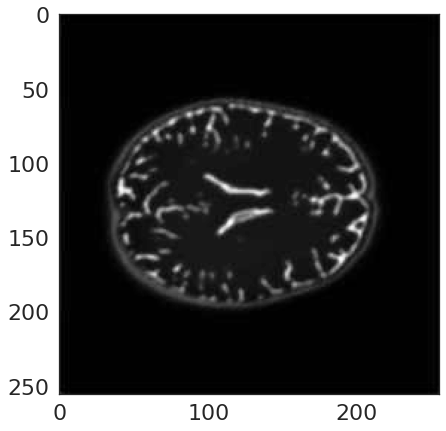

In [ ]:
from PIL import Image
image = Image.open('/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/warped_images/r1_np1.jpg')
data = np.asfarray(image)
plt.figure(figsize=(7,7))
plt.imshow(data, cmap="Greys_r")

In [ ]:
b1 = beta_lst[1][0]
b2 = beta_lst[1][1]

u1 = unet_lst[0][0]
u2 = unet_lst[1][0]
u3 = unet_lst[2][0]

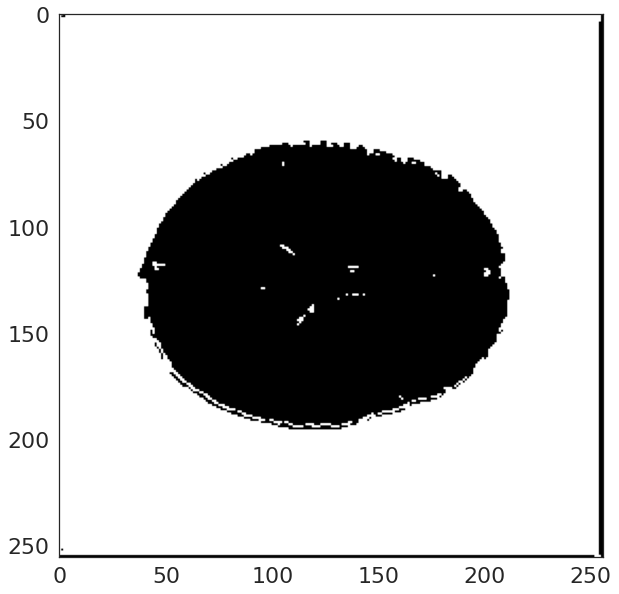

In [ ]:
plt.imshow(b1[0, 2, :, :], cmap="Greys_r")



In [ ]:
np.histogram(b1[0, 0, :, :].flatten())

(array([61855,     0,     0,     0,     0,     0,     0,     0,     0,
         3681]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32))

In [ ]:
print(b1[0, 1, 251, 250], b1[0, 2, 251, 250])

1.0 0.0


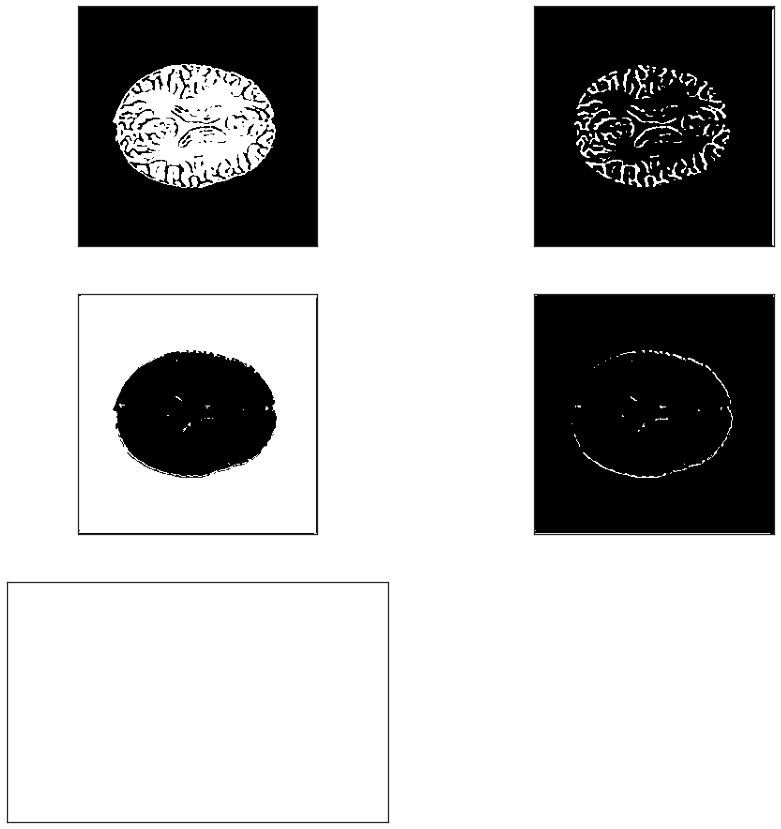

In [ ]:
plt.figure(figsize=(15,15))
for i in range(0, 5):
  plt.subplot(3 , 2, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  if( i < 4):
    plt.imshow(b1[0, i, :, :], cmap="Greys_r")
plt.show()

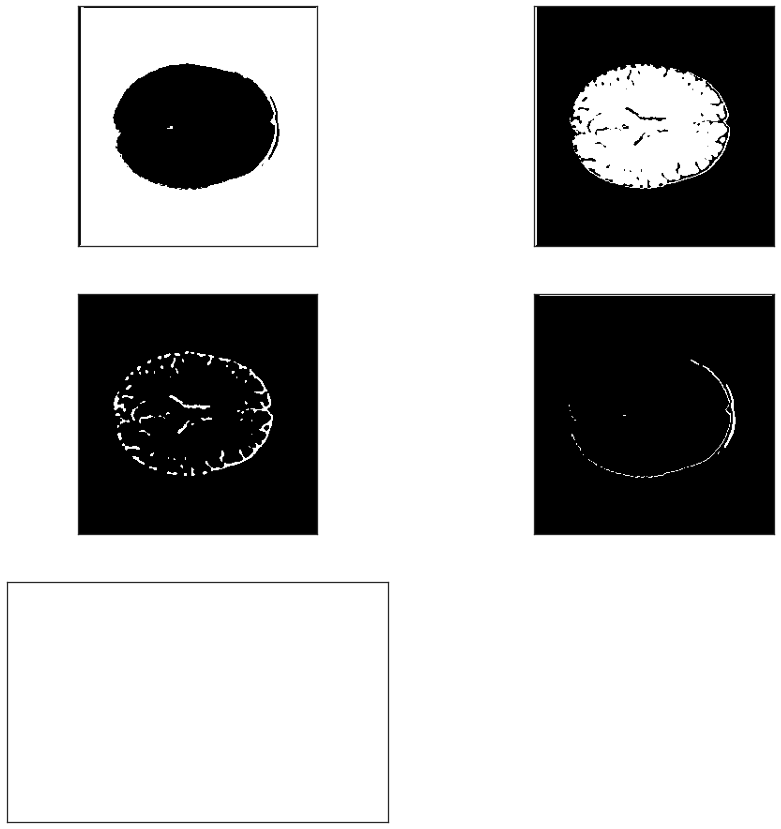

In [ ]:
plt.figure(figsize=(15,15))
for i in range(0, 5):
  plt.subplot(3 , 2, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  if( i < 4):
    plt.imshow(b2[0, i, :, :], cmap="Greys_r")
plt.show()

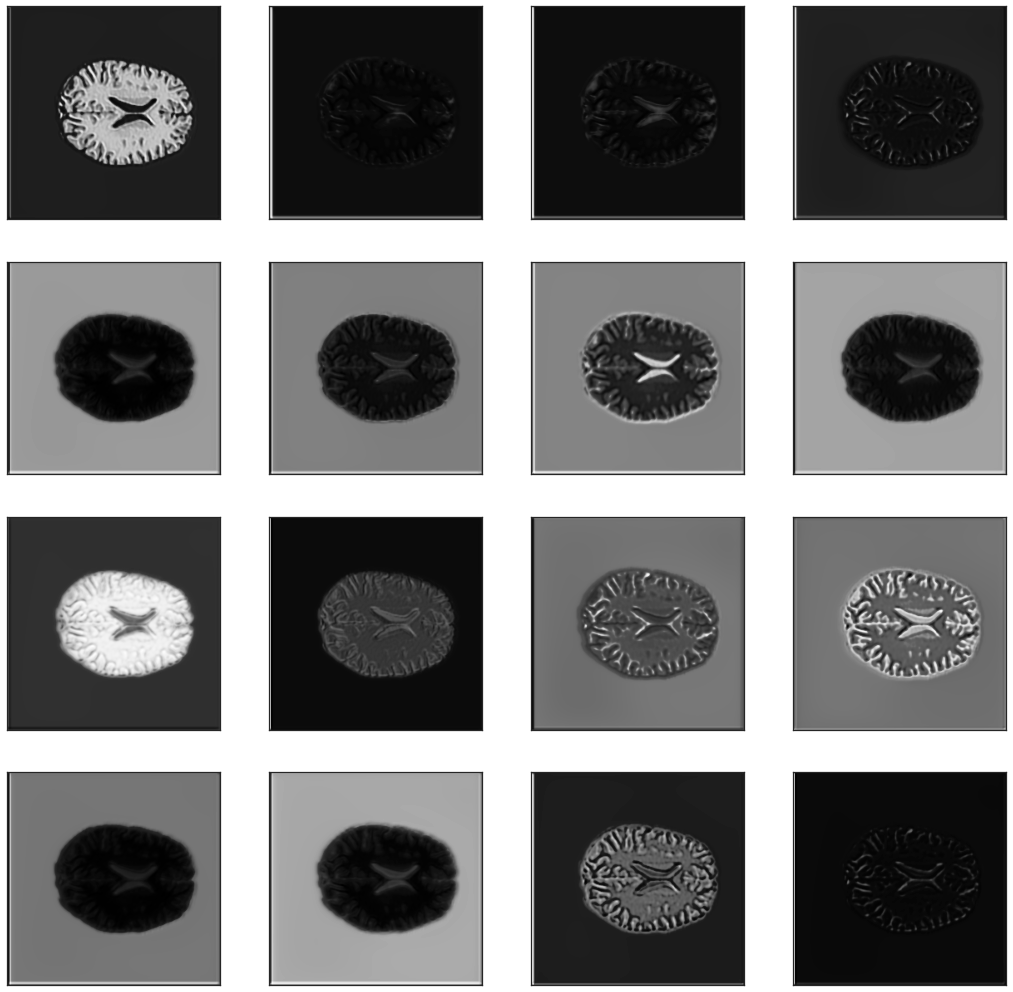

In [ ]:
plt.figure(figsize=(18,18))
for i in range(0, 16):
  plt.subplot(4 , 4, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(u1[i, :, :], cmap="Greys_r")
plt.show()

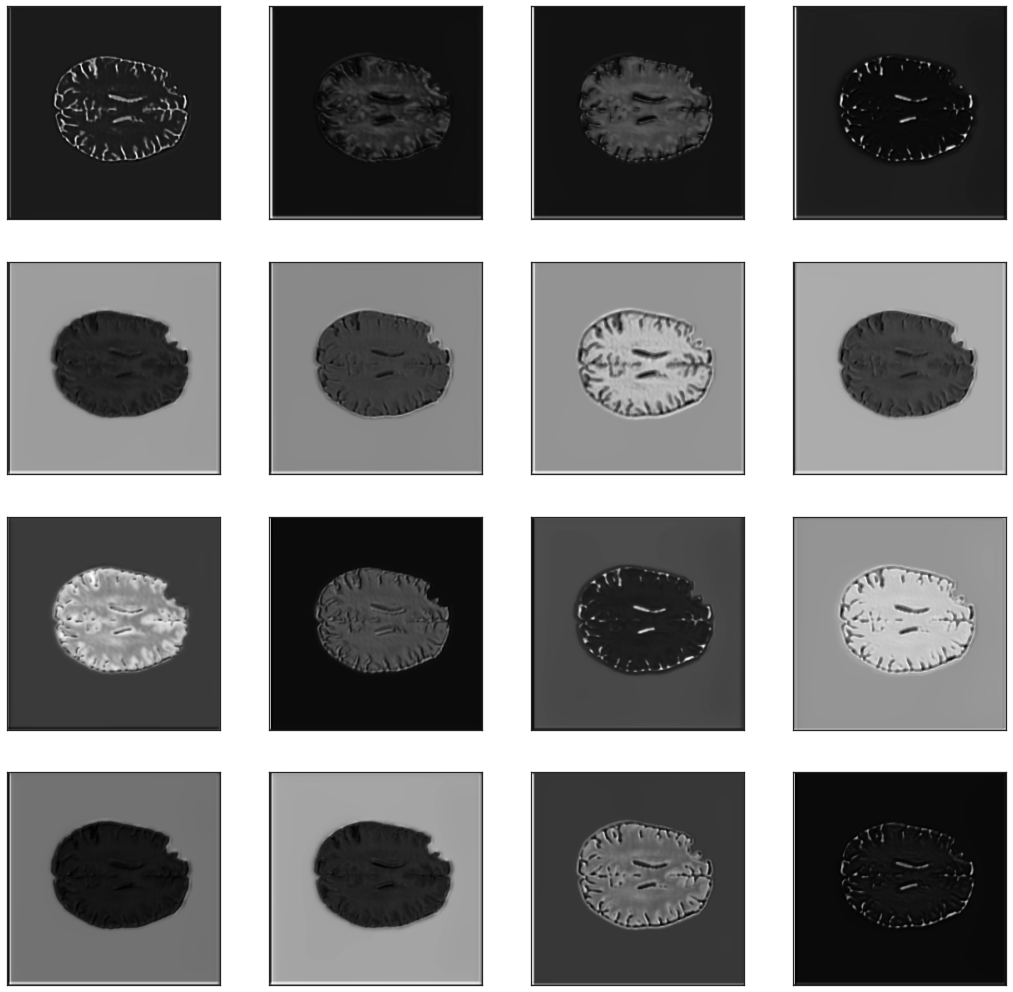

In [ ]:
plt.figure(figsize=(18,18))
for i in range(0, 16):
  plt.subplot(4 , 4, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(u2[i, :, :], cmap="Greys_r")
plt.show()

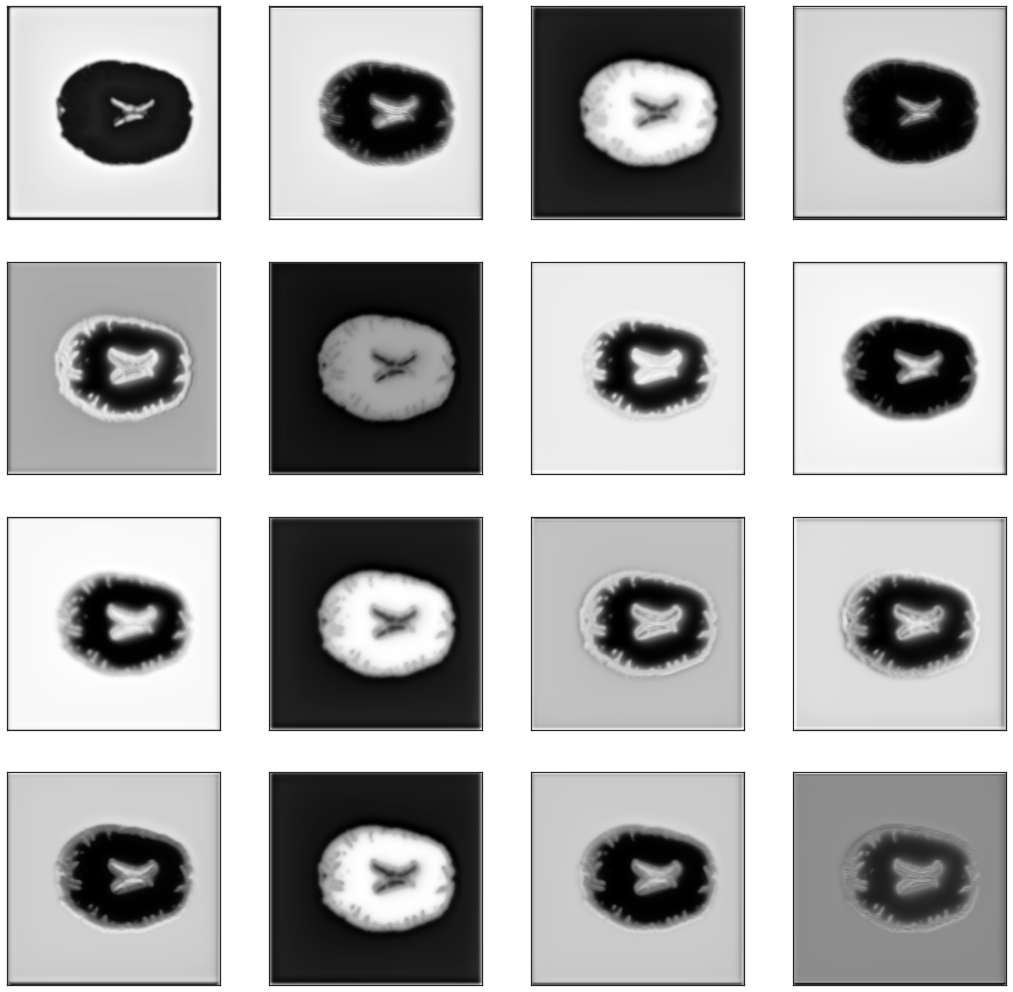

In [ ]:
plt.figure(figsize=(18,18))
for i in range(0, 16):
  plt.subplot(4 , 4, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(u3[i, :, :], cmap="Greys_r")
plt.show()

In [ ]:
def inference_run(epoch=1):
  example_number = 0
  beta_np_lst = []
  unet_lst = []
  probmaps_np_lst = []
  for X,Y in inference_generator:

    X = X.float().to("cuda")
    Y = Y.float().to("cuda")

    x_size = X.size()

    u_x = encoder_unet_model_inference(X)
    p_x, o_x, s_x = betahead_inference(u_x, hard_flag=True, tau=0.1)
    t_x  = thetahead_inference(u_x)
    print(u_x.shape)
    print(t_x)

    unet_lst.append(u_x.detach().cpu().numpy())

    u_y = encoder_unet_model_inference(Y)
    p_y, o_y, s_y = betahead_inference(u_y, hard_flag=True, tau=0.5)
    t_y  = thetahead_inference(u_y)
    print(t_y)

    unet_lst.append(u_y.detach().cpu().numpy())

    # theta1_reconstructed = t_x.repeat(1, 128, 128).reshape(x_size[0], 1, 128, 128)
    # theta2_reconstructed = t_y.repeat(1, 128, 128).reshape(x_size[0], 1, 128, 128)

    # input_recon1 = torch.cat((o_x, theta1_reconstructed), 1)
    # input_recon2 = torch.cat((o_x, theta2_reconstructed), 1)
    # input_recon3 = torch.cat((o_y, theta1_reconstructed), 1)
    # input_recon4 = torch.cat((o_y, theta2_reconstructed), 1)

    input_recon1, input_recon2, input_recon3, input_recon4 = randomizehead_inference(o_x, o_y, t_x, t_y)

    d1 = decoder_unet_model_inference(input_recon1)
    d2 = decoder_unet_model_inference(input_recon2)
    d3 = decoder_unet_model_inference(input_recon3)
    d4 = decoder_unet_model_inference(input_recon4)

    unet_lst.append(d1.detach().cpu().numpy())
    beta_np_lst.append([o_x.detach().cpu().numpy(), o_y.detach().cpu().numpy()])

    r1 = reconstructionhead_inference(d1)
    r2 = reconstructionhead_inference(d2)
    r3 = reconstructionhead_inference(d3)
    r4 = reconstructionhead_inference(d4)

    r1_np = r1.detach().cpu().numpy()
    r2_np = r2.detach().cpu().numpy()
    r3_np = r3.detach().cpu().numpy()
    r4_np = r4.detach().cpu().numpy()

    

    p_y_np = p_y.detach().cpu().numpy()
    p_x_np = p_x.detach().cpu().numpy()
    probmaps_np_lst.append([p_x_np, p_y_np])

    imageio.imwrite('/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/warped_images/r1_np'+str(example_number)+".jpg", r1_np[0, 0, :, :])
    imageio.imwrite('/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/warped_images/r2_np'+str(example_number)+".jpg", r2_np[0, 0, :, :])
    imageio.imwrite('/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/warped_images/r3_np'+str(example_number)+".jpg", r3_np[0, 0, :, :])
    imageio.imwrite('/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/warped_images/r4_np'+str(example_number)+".jpg", r4_np[0, 0, :, :])

    del X, Y, u_x, p_x, t_x, u_y, p_y, t_y, input_recon1, input_recon2, input_recon3, input_recon4, r1, r2, r3, r4, d1,d2, d3, d4
    torch.cuda.empty_cache()    
    example_number = example_number + 1

    if(example_number > 4):
      break;
    
  
  return beta_np_lst, unet_lst, probmaps_np_lst

In [ ]:
beta_lst, unet_lst, probmaps_np_lst = inference_run(epoch=1)

torch.Size([1, 16, 256, 256])
tensor([[-3.5469]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-4.6975]], device='cuda:0', grad_fn=<AddmmBackward>)


torch.Size([1, 16, 256, 256])
tensor([[-3.7444]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-51.4773]], device='cuda:0', grad_fn=<AddmmBackward>)


torch.Size([1, 16, 256, 256])
tensor([[-3.7291]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-23.1644]], device='cuda:0', grad_fn=<AddmmBackward>)


torch.Size([1, 16, 256, 256])
tensor([[-4.1283]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-44.7440]], device='cuda:0', grad_fn=<AddmmBackward>)


torch.Size([1, 16, 256, 256])
tensor([[-3.8503]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-4.4555]], device='cuda:0', grad_fn=<AddmmBackward>)


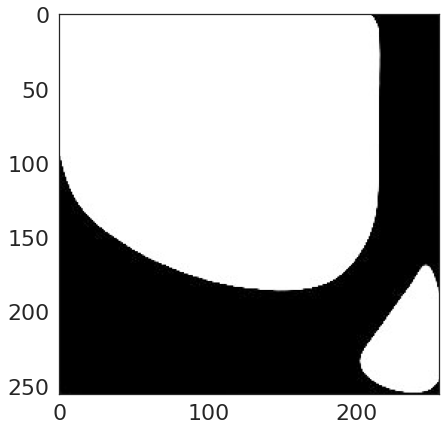

In [ ]:
from PIL import Image
image = Image.open('/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/warped_images/r1_np1.jpg')
data = np.asfarray(image)
plt.figure(figsize=(7,7))
plt.imshow(data, cmap="Greys_r")

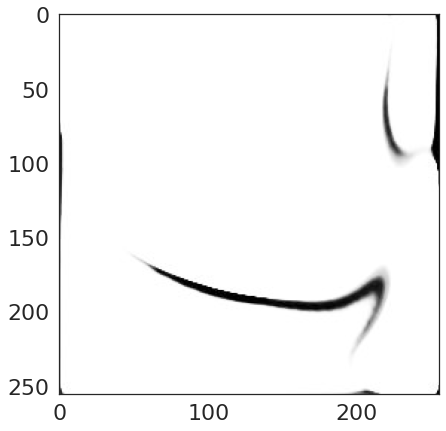

In [ ]:
from PIL import Image
image = Image.open('/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/warped_images/r2_np1.jpg')
data = np.asfarray(image)
plt.figure(figsize=(7,7))
plt.imshow(data, cmap="Greys_r")

In [ ]:
b1 = beta_lst[2][0]
b2 = beta_lst[2][1]

p1 = probmaps_np_lst[0][0]
p2 = probmaps_np_lst[0][1]

u1 = unet_lst[0][0]
u2 = unet_lst[1][0]
u3 = unet_lst[2][0]

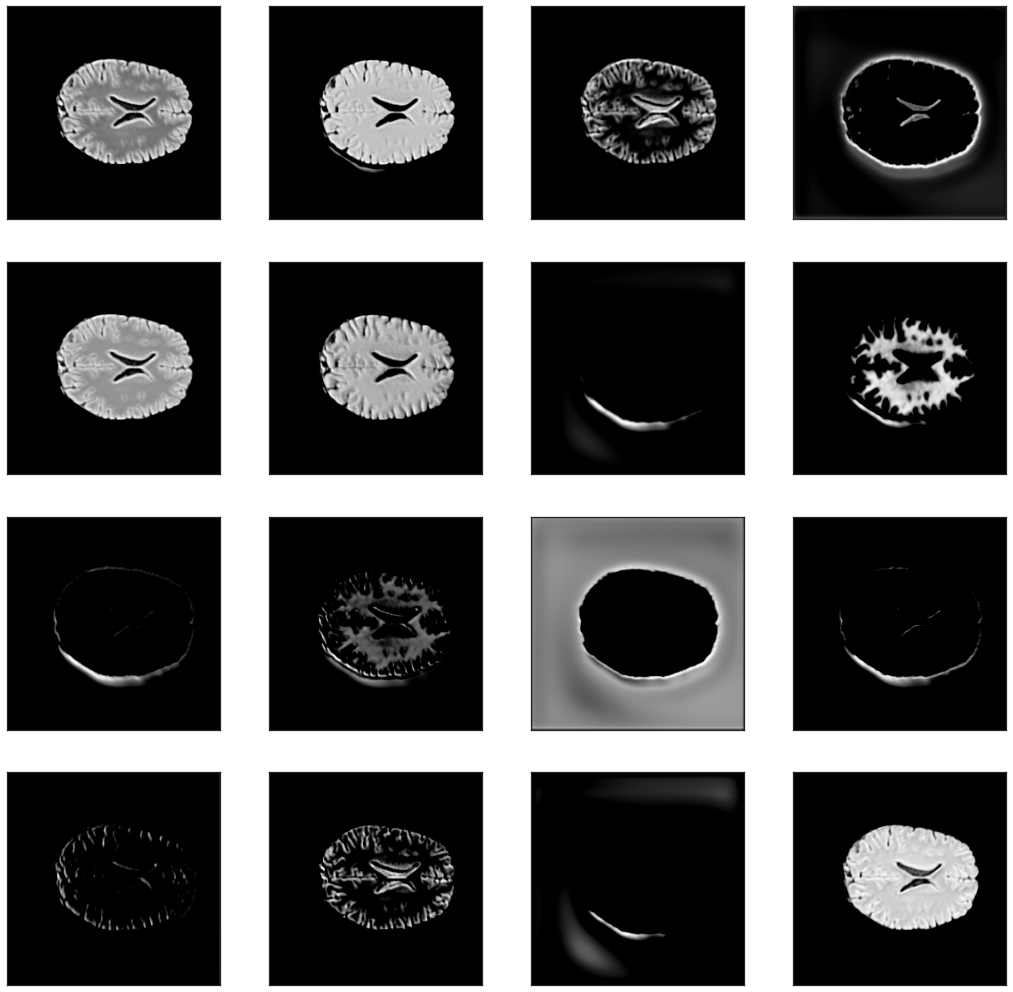

In [ ]:
plt.figure(figsize=(18,18))
for i in range(0, 16):
  plt.subplot(4 , 4, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(u1[i, :, :], cmap="Greys_r")
plt.show()

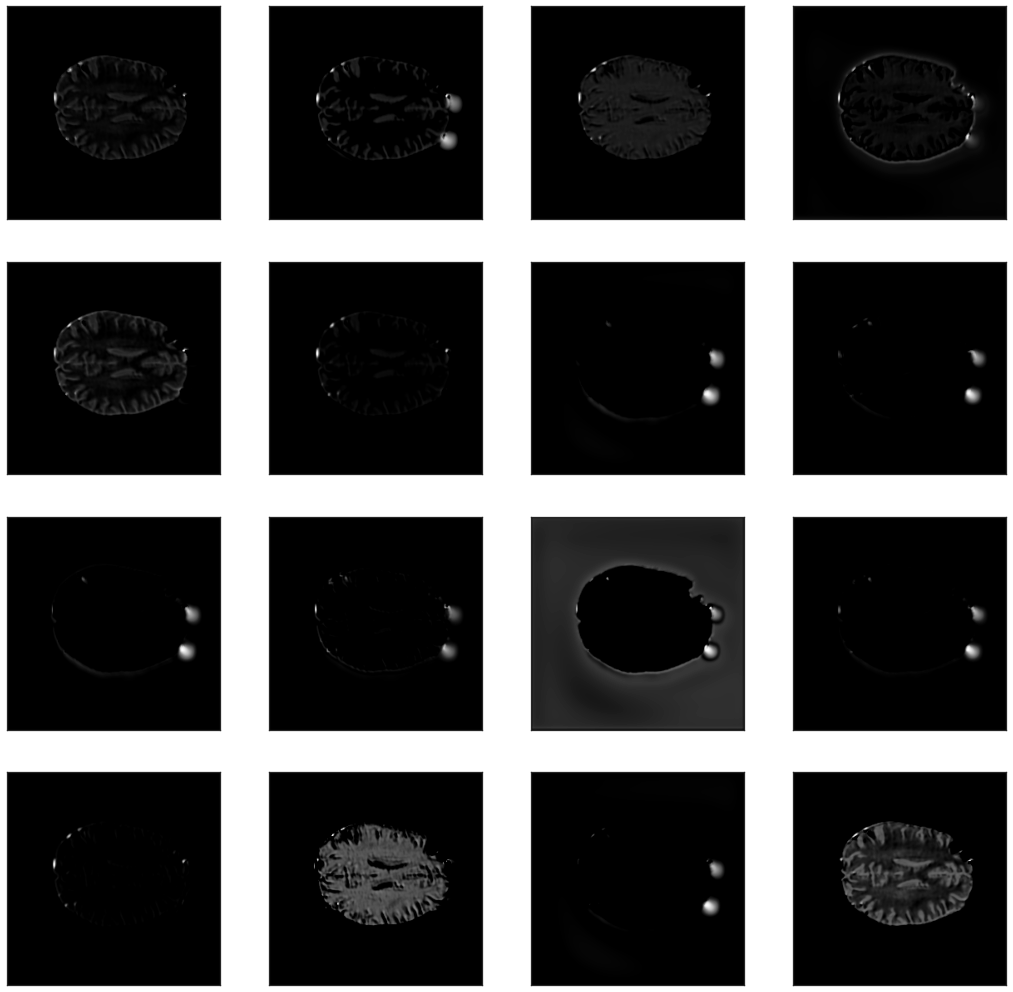

In [ ]:
plt.figure(figsize=(18,18))
for i in range(0, 16):
  plt.subplot(4 , 4, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(u2[i, :, :], cmap="Greys_r")
plt.show()

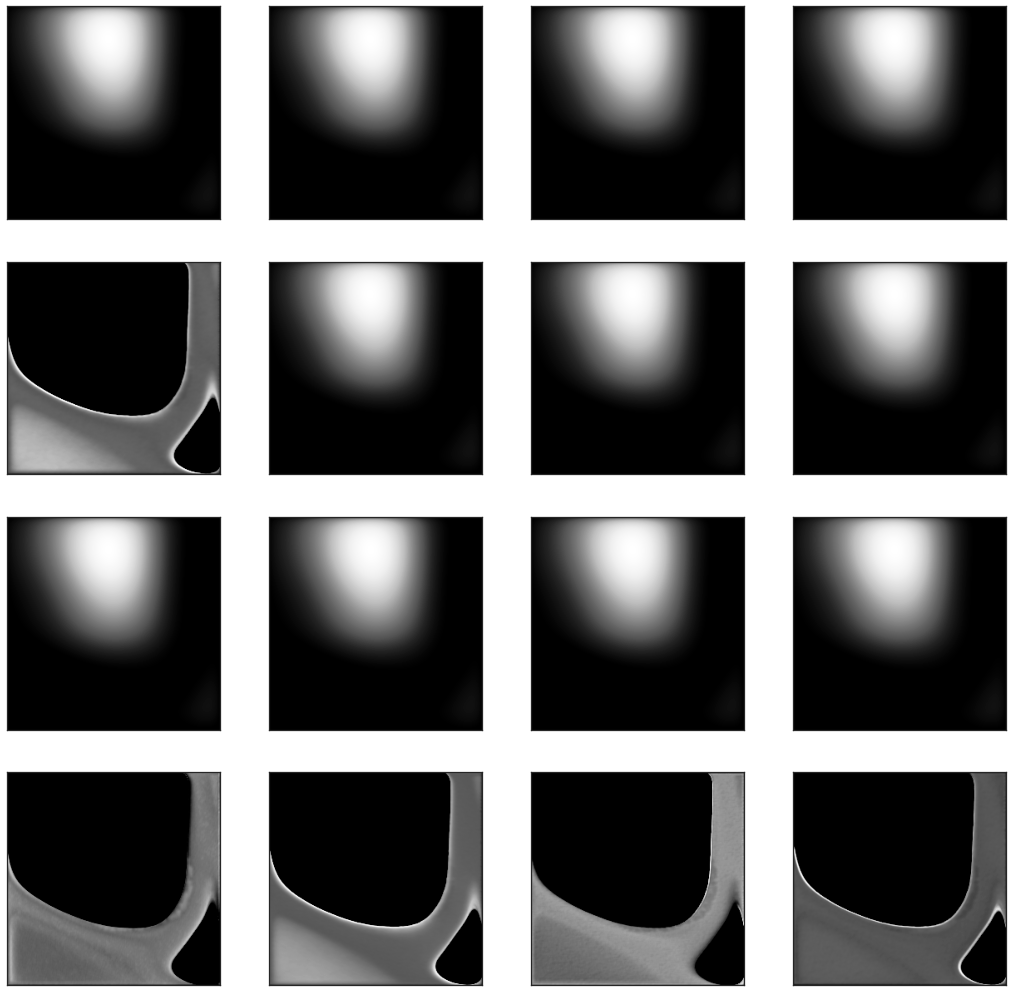

In [ ]:
plt.figure(figsize=(18,18))
for i in range(0, 16):
  plt.subplot(4 , 4, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(u3[i, :, :], cmap="Greys_r")
plt.show()

IndexError: ignored

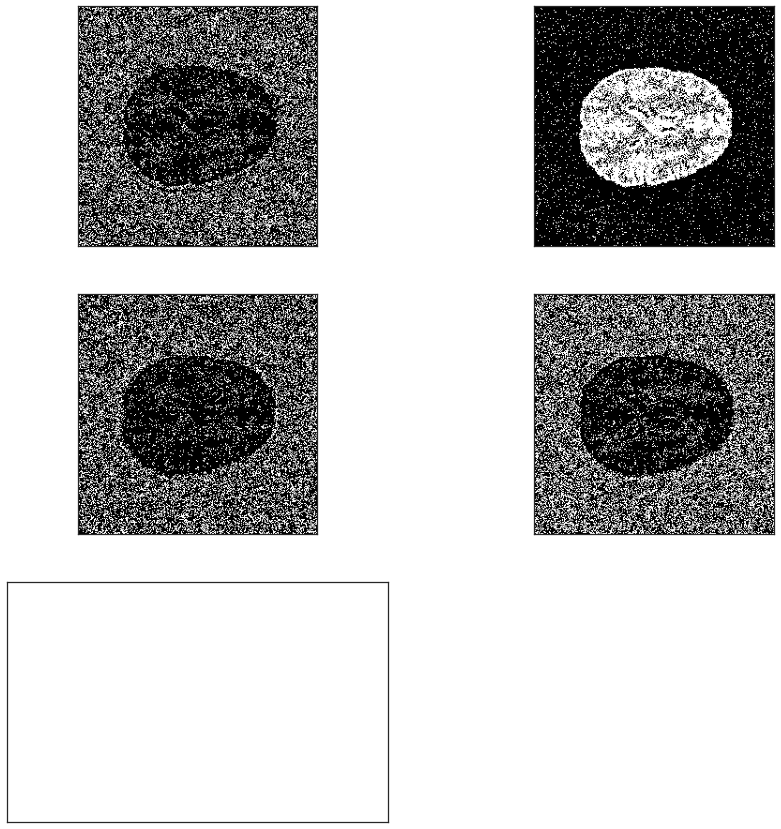

In [ ]:
plt.figure(figsize=(15,15))
for i in range(0, 6):
  plt.subplot(3 , 2, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  if( i < 5):
    plt.imshow(b1[0, i, :, :], cmap="Greys_r")
plt.show()

IndexError: ignored

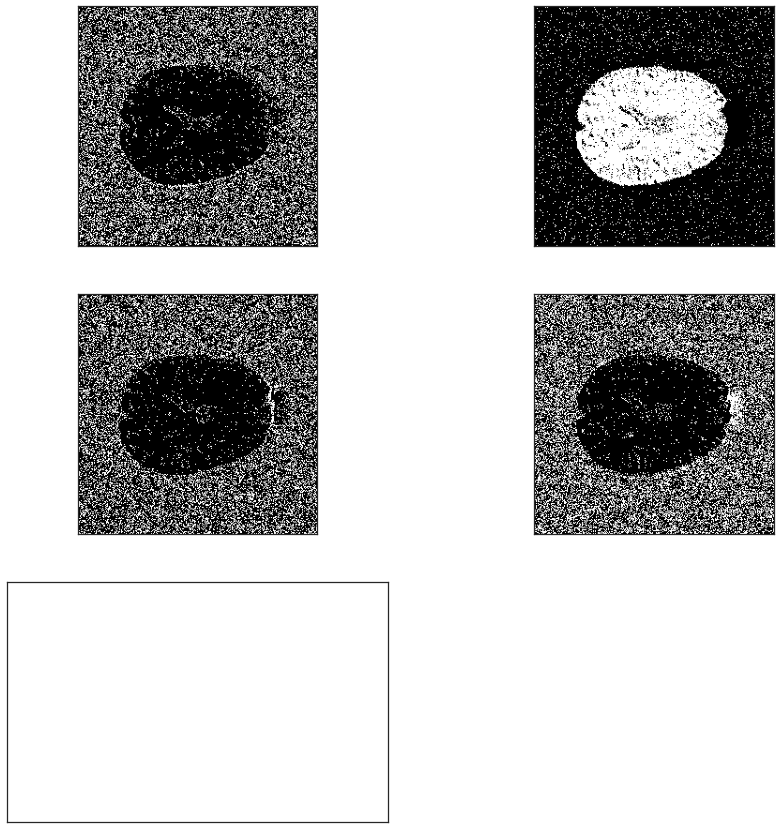

In [ ]:
plt.figure(figsize=(15,15))
for i in range(0, 6):
  plt.subplot(3 , 2, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  if( i < 5):
    plt.imshow(b2[0, i, :, :], cmap="Greys_r")
plt.show()